# Kaggle Getting Started Competition: Titanic Dataset
12/30/18 Jonathan Cai  

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn import svm, preprocessing, neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
sns.set_style('darkgrid')
sns.set_palette('bone')

# 1. Exploration

In [3]:
df_train_raw = pd.read_csv('data/train.csv')
df_test_raw = pd.read_csv('data/test.csv')
df_train = df_train_raw.copy()
df_test = df_test_raw.copy()
display(df_train.head())
display(df_test.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
df_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
df_train_raw.describe().drop('count').T

,mean,std,min,25%,50%,75%,max
PassengerId,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


### Bivariate Analysis
Look at variables one by one

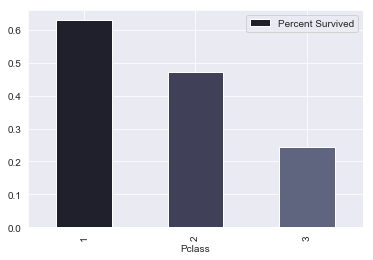

In [6]:
var = 'Pclass'
data = pd.concat([df_train['Survived'], df_train[var]], axis=1)
agg_data = data.groupby(var).agg(sum)
agg_data['Percent Survived'] = agg_data['Survived'] / data.groupby(var).count()['Survived']
agg_data.reset_index(inplace=True)
agg_data.plot.bar(x=var, y='Percent Survived')

The feature `Pclass` seems to have strong negative correlation with survival, which makes sense - those with socioeconomic status survived at higher percentage.

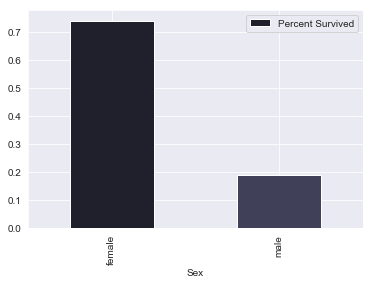

In [7]:
var = 'Sex'
data = pd.concat([df_train['Survived'], df_train[var]], axis=1)
agg_data = data.groupby(var).agg(sum)
agg_data['Percent Survived'] = agg_data['Survived'] / data.groupby(var).count()['Survived']
agg_data.reset_index(inplace=True)
agg_data.plot.bar(x=var, y='Percent Survived')

There also appears to be a strong correlation between `Sex` and survival. 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


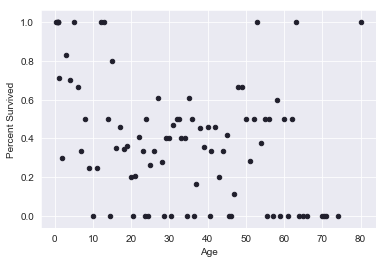

In [8]:
var = 'Age'
data = pd.concat([df_train['Survived'], df_train[var]], axis=1)
agg_data = data.groupby(var).agg(sum)
agg_data['Percent Survived'] = agg_data['Survived'] / data.groupby(var).count()['Survived']
agg_data.reset_index(inplace=True)
agg_data.plot.scatter(x=var, y='Percent Survived')

As for `Age`, it's clear that survival favored the children under 10, and even some older outliers (although, my guess is that were far fewer older people). In the middle ages around 20-50, the data was far more scattered. Maybe instead of percentages, a visualization of the raw counts might be more hepful.

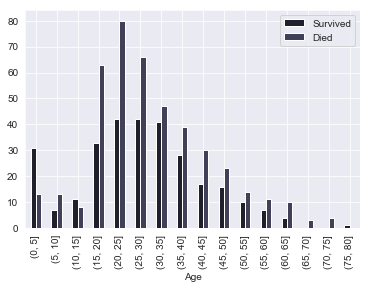

In [9]:
agg_data = data.groupby(pd.cut(data[var], np.arange(0, 85, 5))).sum()
agg_data['Died'] = data.groupby(pd.cut(data[var], np.arange(0, 85,5))).count()['Survived'] - agg_data['Survived']
agg_data.drop(['Age'], axis=1, inplace=True)
agg_data.plot.bar()

There was clearly far more middle aged people, although I'm not sure what to make of this visualization tbh in terms of correlation with survival rates.

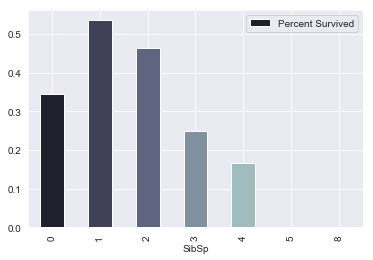

In [10]:
var = 'SibSp'
data = pd.concat([df_train['Survived'], df_train[var]], axis=1)
agg_data = data.groupby(var).agg(sum)
agg_data['Percent Survived'] = agg_data['Survived'] / data.groupby(var).count()['Survived']
agg_data.reset_index(inplace=True)
agg_data.plot.bar(x=var, y='Percent Survived')

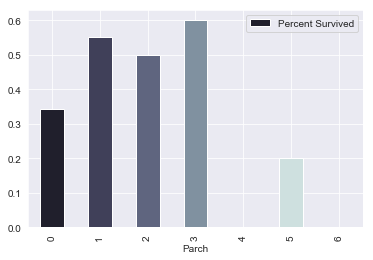

In [11]:
var = 'Parch'
data = pd.concat([df_train['Survived'], df_train[var]], axis=1)
agg_data = data.groupby(var).agg(sum)
agg_data['Percent Survived'] = agg_data['Survived'] / data.groupby(var).count()['Survived']
agg_data.reset_index(inplace=True)
agg_data.plot.bar(x=var, y='Percent Survived')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


DescribeResult(nobs=891, minmax=(0.0, 512.3292), mean=32.204207968574636, variance=2469.436845743116, skewness=4.7792532923723545, kurtosis=33.20428925264474)

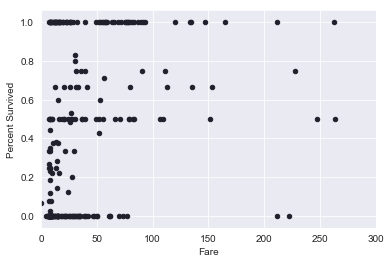

In [12]:
var = 'Fare'
data = pd.concat([df_train['Survived'], df_train[var]], axis=1)
agg_data = data.groupby(var).agg(sum)
agg_data['Percent Survived'] = agg_data['Survived'] / data.groupby(var).count()['Survived']
agg_data.reset_index(inplace=True)
agg_data.plot.scatter(x=var, y='Percent Survived', xlim=(0,300))
fares = np.array(data[var])
stats.describe(fares)

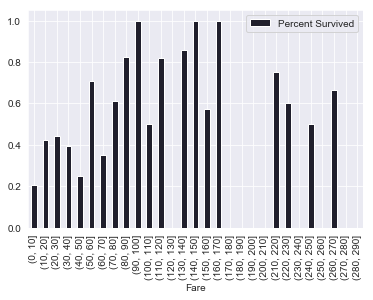

In [13]:
agg_data = data.groupby(pd.cut(data[var], np.arange(0, 300, 10))).sum()
agg_data['Percent Survived'] = agg_data['Survived'] / data.groupby(pd.cut(data[var], np.arange(0, 300,10))).count()['Survived']
agg_data.drop([var, 'Survived'], axis=1, inplace=True)
agg_data.plot.bar()

Ignoring the outlier of 512, there does appear to be some sort of positive correlation between `Fare` and the survival rate - somewhat expected, as fare price may also be indicative of socioeconomic status, which had high correlation with survival.

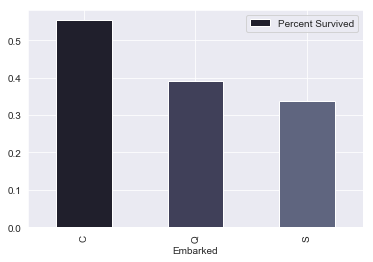

In [14]:
var = 'Embarked'
data = pd.concat([df_train['Survived'], df_train[var]], axis=1)
agg_data = data.groupby(var).agg(sum)
agg_data['Percent Survived'] = agg_data['Survived'] / data.groupby(var).count()['Survived']
agg_data.reset_index(inplace=True)
agg_data.plot.bar(x=var, y='Percent Survived')

Thus, it would appear that the features `Pclass` (negatively) and `Fare` (positively) correlate the most with our label, `Survived`. We can confirm our suspicions with a correlation heatmap?

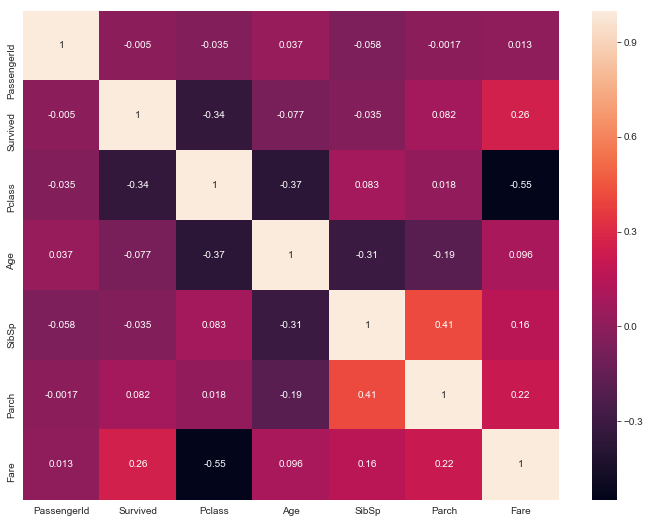

In [15]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, annot=True);

As expected, in the `Survived` row, `Pclass` and `Fare` seem to have the highest correlation, `Pclass` with a strong negative correlation. The strong correlation between `Parch` and `SibSp` stands out, as those with relatives were likely to have both siblings/spouse and parents/children. Also, `Fare` and `Pclass` have a very strong negative correlation - which confirms previous suspicions.

# 2. Feature Selection, Cleaning
## Missing Data

In [16]:
df_train = df_train_raw.copy()
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


With 77% of `Cabin` data missing, I'm going to drop the feature entirely... good idea???? Look into this???  
As for `Age`, it intuitively seems like valuable information, even though the single scatter plot against survival percentage did not seem to show much pattern, except slightly favoring the extremes of young/old. Nonetheless, I want to keep this data, but too much (20%) is missing. I will replace these values with the mean age.  
Lastly, for the two missing `Embarked` data, I will simply delete those two points and keep the feature.  
I will also be dropping `Name` and `Ticket` and `PassengerId`, as I am making the assumption that both will always be unique - maybe `Ticket` number could indicate time data, as those embarking earlier would have a lesser number? - But I am assuming this is already encoded into `Embarked`.

In [17]:
df_train = df_train_raw.copy()
df_train.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)
mean_age = np.array(df_train['Age'].dropna()).mean()
print("Mean age : " + str(mean_age))
df_train['Age'].fillna(mean_age, inplace=True)
df_train = df_train[pd.notnull(df_train['Embarked'])]
df_train.head()

Mean age : 29.69911764705882


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [18]:
df_train.isnull().sum().max()

0

## Outliers
Not doing anything currently, but may want to do something about the row with fare=512

## Categorical Data
Dummy variables for `Sex` and `Embarked`.

In [19]:
df_train = pd.get_dummies(df_train).drop(['Sex_male', 'Embarked_S'], axis=1)
df_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Embarked_C,Embarked_Q
0,0,3,22.0,1,0,7.2500,0,0,0
1,1,1,38.0,1,0,71.2833,1,1,0
2,1,3,26.0,0,0,7.9250,1,0,0
3,1,1,35.0,1,0,53.1000,1,0,0
4,0,3,35.0,0,0,8.0500,0,0,0


## Some Engineering
Going to add `SibSp` and `Parch` and 1 to get a new feature `Family`.

In [20]:
df_train['Family'] = df_train['SibSp'] + df_train['Parch'] + 1
df_train.drop(['SibSp', 'Parch'], axis=1, inplace=True)
df_train.head()

,Survived,Pclass,Age,Fare,Sex_female,Embarked_C,Embarked_Q,Family
0,0,3,22.0,7.2500,0,0,0,2
1,1,1,38.0,71.2833,1,1,0,2
2,1,3,26.0,7.9250,1,0,0,1
3,1,1,35.0,53.1000,1,0,0,2
4,0,3,35.0,8.0500,0,0,0,1


# 3. Modeling / CV

In [86]:
percent_training = .8
test_cols = ['Embarked_C', 'Embarked_Q']
# test_cols = []
X = np.array(df_train.drop(['Survived'] + test_cols, axis=1))
y = np.array(df_train['Survived'])
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1 - percent_training))

kf = KFold(n_splits=5, random_state=None) 

# clf = DecisionTreeClassifier(min_samples_split=15, min_samples_leaf=20, random_state=42)
# clf = LogisticRegression(random_state=42, max_iter=300, solver='lbfgs')
# clf = neighbors.KNeighborsClassifier()
clf = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=None)

# Kfold cross validation
accuracies = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    accuracies.append(accuracy)
    
print("Variance:", np.var(np.asarray(accuracies)))
print("Mean:", np.mean(np.asarray(accuracies)))

Variance: 0.0009923128949382214
Mean: 0.835809052244017


# 4. Predicting Out
Generate predictions for actual test set.

First, we need to transform the columns/data of the test set.

In [87]:
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [88]:
df_test = df_test_raw.copy()
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
Cabin,327,0.782297
Age,86,0.205742
Fare,1,0.002392
Embarked,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


Turns out, we have a single missing fare data point. I will replace with the median...

In [90]:
# Drop features
df_test.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

# Replace NaN ages with mean age
mean_age = np.array(df_test['Age'].dropna()).mean()
print("Mean age : " + str(mean_age))
df_test['Age'].fillna(mean_age, inplace=True)

# Replace NaN fare with median fare
median_fare = np.median(np.array(df_test['Fare'].dropna()))
print("Median fare : " + str(median_fare))
df_test['Fare'].fillna(median_fare, inplace=True)

# Dummy data
df_test = pd.get_dummies(df_test).drop(['Sex_male', 'Embarked_S'] + test_cols, axis=1)
df_test.head()

# Get new feature, family
df_test['Family'] = df_test['SibSp'] + df_test['Parch'] + 1
df_test.drop(['SibSp', 'Parch'], axis=1, inplace=True)
df_test.head()

Mean age : 30.272590361445783
Median fare : 14.4542


,Pclass,Age,Fare,Sex_female,Family
0,3,34.5,7.8292,0,1
1,3,47.0,7.0000,1,2
2,2,62.0,9.6875,0,1
3,3,27.0,8.6625,0,1
4,3,22.0,12.2875,1,3


In [91]:
df_test.isnull().sum().max()

0

Now, we can generate the predictions.

In [92]:
predictions = clf.predict(df_test.values)
res = pd.concat([pd.read_csv('data/test.csv')['PassengerId'], pd.DataFrame(predictions, columns=['Survived'])], axis=1)
res.set_index('PassengerId', inplace=True)
res.to_csv('submission.csv')
res.head(10)

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1
897,0
898,0
899,0
900,1
